# Load data and common preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    StratifiedKFold,
    LeaveOneOut,
    GridSearchCV,
    cross_val_predict,    # cross_val_predict: function that returns predictions for each cross-validation fold
    learning_curve,       # learning_curve: function that computes training and validation scores as training size grows
    KFold
)
from sklearn.pipeline import Pipeline           # Pipeline: links preprocessing steps to model training
from sklearn.tree import DecisionTreeClassifier # DecisionTreeClassifier: decision tree classification model
from sklearn.neighbors import KNeighborsClassifier  # KNeighborsClassifier: K-nearest neighbors classification model
from sklearn.linear_model import LinearRegression   # LinearRegression: basic linear regression model
from sklearn.preprocessing import PolynomialFeatures # PolynomialFeatures: expands features into polynomial terms
from sklearn.metrics import (
    confusion_matrix,          # confusion_matrix: computes the confusion matrix
    ConfusionMatrixDisplay     # ConfusionMatrixDisplay: tool to plot the confusion matrix
)


# [0] Load data and apply common preprocessing
# -------------------------------------------------------------------
df = pd.read_csv("preprocessed_cmu_sleep.csv")  # Load the preprocessed CSV data
df = df[df["frac_nights_with_data"] >= 0.8]      # Keep rows where ≥80% of nights have sleep data

# Features for classification (X_clf, y_clf) and regression (X_reg, y_reg)
feature = [
    "demo_gender",    # gender (0 = male, 1 = female)
    "demo_race",      # race code (0 = minority group, 1 = non-minority)
    "demo_firstgen",  # first-generation status (0 = not first-gen, 1 = first-gen)
    "TotalSleepTime", # total sleep time in minutes
    "bedtime_mssd",   # bedtime variability in minutes
    "midpoint_sleep", # midpoint of sleep period in minutes
    "daytime_sleep",  # daytime sleep duration in minutes
    "Zterm_units_ZofZ", # GPA converted to Z-score
]
X_clf, y_clf = df[feature], df["gpa_class"]  # Classification target: gpa_class (A/B/C/D)
X_reg, y_reg = df[feature], df["term_gpa"]   # Regression target: term_gpa (scale up to 4.0)


In [ ]:
# Calculate and print the percentage of each class in y_clf
percentages = y_clf.value_counts(normalize=True) * 100
print(percentages)

In [ ]:
# Exclude sleep variables
feature = [
    "demo_gender",    # gender (0 = male, 1 = female)
    "demo_race",      # race code (0 = minority group, 1 = non-minority)
    "demo_firstgen",  # first-generation status (0 = not first-gen, 1 = first-gen)
]
X_clf, y_clf = df[feature], df["gpa_class"]  # Classification target: gpa_class (A/B/C/D)
X_reg, y_reg = df[feature], df["term_gpa"]   # Regression target: term_gpa (scale up to 4.0)

In [ ]:
# Only sleep data
feature = [
    "TotalSleepTime",          # total sleep time in minutes
    "bedtime_mssd",            # bedtime variability in minutes
    "midpoint_sleep",          # midpoint of sleep period in minutes
    "daytime_sleep",           # daytime sleep duration in minutes
    "sleep_consistency_index", # sleep consistency index
    "sleep_efficiency_z",      # sleep efficiency relative to academic load
    "day_night_ratio",         # proportion of daytime sleep
    "sleep_debt"               # sleep debt
]
X_clf, y_clf = df[feature], df["gpa_class"]  # Classification target: gpa_class (A/B/C/D)
X_reg, y_reg = df[feature], df["term_gpa"]   # Regression target: term_gpa (scale up to 4.0)


# Classification function



In [ ]:
# [1] classification function
# -------------------------------------------------------------------
def def_clf(model, param_grid, k_values=[3,5,7]):
    """
    model       : model instance
    param_grid  : parameters for GridSearchCV
    k_values    : number of folds for KFold
    """

    # 1) Run GridSearchCV for each k in k_values and save results
    records = []
    for k in k_values:
        cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        gs = GridSearchCV(
            Pipeline([("model", model)]),  # Pipeline: ('model', model object)
            param_grid,
            cv=cv,
            scoring="accuracy",            # scoring metric: accuracy
            n_jobs=-1,                     # use all CPU cores
            verbose=1                      # print progress
        )
        gs.fit(X_clf, y_clf)              # fit the model and perform CV

        # convert results to DataFrame
        dfcv = pd.DataFrame(gs.cv_results_)
        dfcv["k"] = k                   # record which k produced these results
        records.append(dfcv)

    # 2) Combine results across k and rename columns
    dfall = pd.concat(records, ignore_index=True)
    dfall = dfall.rename(columns={
        "mean_test_score": "accuracy",  # average accuracy
    })

    # 3) Sort by accuracy descending and extract top 5
    dftop = dfall.sort_values("accuracy", ascending=False).head(5)

    # 4) Print top 5
    print(f"\n[{model.__class__.__name__}] Top-5 across k={k_values} (CV Accuracy)")
    print(dftop[["k","accuracy","params"]])

    # 5) The first row among the top 5 is the final best
    best = dftop.iloc[0]
    best_k, best_acc, best_params = int(best["k"]), best["accuracy"], best["params"]
    print(f"\n→ Final Best: k={best_k}, accuracy={best_acc:.4f}, params={best_params}")

    # 6) Plot confusion matrix for the best model
    best_pipe = Pipeline([("model", model)])
    best_pipe.set_params(**best_params) # set parameters found by grid search
    best_pipe.fit(X_clf, y_clf)         # retrain on full data to get classes
    cvb = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=42)
    ypred = cross_val_predict(best_pipe, X_clf, y_clf, cv=cvb)
    cm = confusion_matrix(y_clf, ypred,
                          labels=best_pipe.named_steps["model"].classes_)
    disp = ConfusionMatrixDisplay(cm,
             display_labels=best_pipe.named_steps["model"].classes_)
    disp.plot()
    disp.ax_.set_title(f"{model.__class__.__name__} CM (k={best_k})")

    # 7) Plot the learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        best_pipe,             # model to evaluate: best model
        X_clf, y_clf,          # input data and labels
        cv=cvb,                # StratifiedKFold
        scoring="accuracy",    # scoring metric: accuracy
        train_sizes=np.linspace(0.1, 1.0, 5),  # training sample proportions
        n_jobs=-1
    )

    # axis=1: group fold scores for each training proportion
    train_mean = train_scores.mean(axis=1)  # training set accuracy
    train_std  = train_scores.std(axis=1)   # training set standard deviation
    val_mean   = val_scores.mean(axis=1)    # validation set accuracy
    val_std    = val_scores.std(axis=1)     # validation set standard deviation

    plt.figure()
    plt.plot(train_sizes, train_mean, label="Train Acc")  # plot training accuracy
    plt.fill_between(train_sizes,
                     train_mean - train_std,
                     train_mean + train_std,
                     alpha=0.2)  # shade area by one standard deviation
    plt.plot(train_sizes, val_mean, label="Valid Acc")   # plot validation accuracy
    plt.fill_between(train_sizes,
                     val_mean - val_std,
                     val_mean + val_std,
                     alpha=0.2)  # shade area by one standard deviation
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.title(f"{model.__class__.__name__} Learning Curve (k={best_k})")
    plt.legend()
    plt.show()

    return dftop  # return the top-5 DataFrame


# Run Classification

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 7 folds for each of 72 candidates, totalling 504 fits

[DecisionTreeClassifier] Top-5 across k=[3, 5, 7] (CV Accuracy)
     k  accuracy                                             params
154  7  0.397604  {'model__criterion': 'gini', 'model__max_depth...
156  7  0.397575  {'model__criterion': 'gini', 'model__max_depth...
157  7  0.397575  {'model__criterion': 'gini', 'model__max_depth...
153  7  0.395563  {'model__criterion': 'gini', 'model__max_depth...
155  7  0.395534  {'model__criterion': 'gini', 'model__max_depth...

→ Final Best: k=7, accuracy=0.3976, params={'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5}
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 7 folds for each of 200 candidates, totalling 140

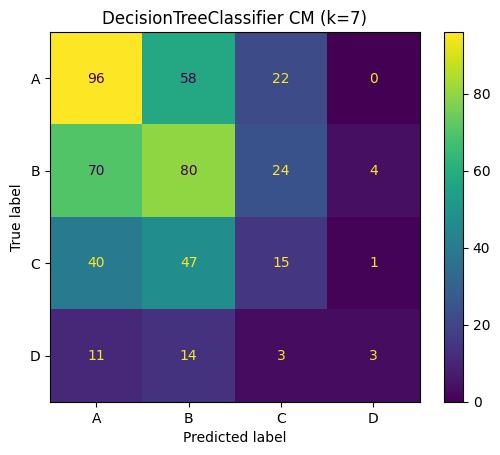

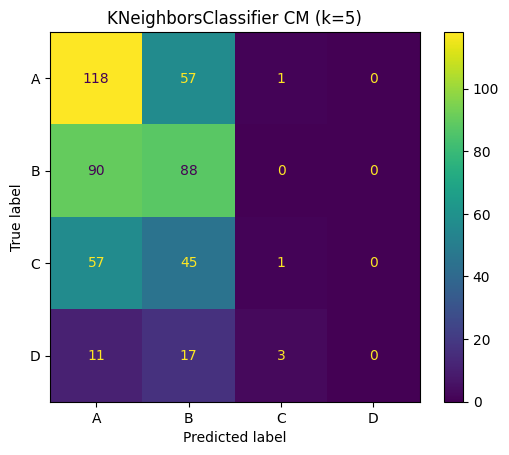

In [ ]:
# 7) Set params for each model
# DecisionTree params setup
dt_params = {
    "model__criterion":        ["gini","entropy"],
    "model__max_depth":        [None,5,10,20],
    "model__min_samples_split":[2,5,10],
    "model__min_samples_leaf": [1,2,4]
}
# KNN params setup
knn_params = {
    "model__n_neighbors": list(range(1,51)),
    "model__weights":     ["uniform","distance"],
    "model__p":           [1,2]
}

# 8) Call function for each model
# call function (DecisionTree)
dt = def_clf(DecisionTreeClassifier(random_state=42),
             dt_params, k_values=[3,5,7])
# call function (knn)
knn = def_clf(KNeighborsClassifier(),
              knn_params, k_values=[3,5,7])

# Regression function

In [ ]:
from sklearn.metrics import mean_squared_error

# [2] regression function
# -------------------------------------------------------------------
def def_reg(model, param_grid, k_values=[3,5,7]):
    """
    model       : regression model instance
    param_grid  : parameter grid for GridSearchCV
    k_values    : list of KFold splits to use for the learning curve
    """
    # 1) Run GridSearchCV for each k in k_values
    records = []
    for k in k_values:
        cv = KFold(n_splits=k, shuffle=True, random_state=42)
        gs = GridSearchCV(
            Pipeline([("model", model)]),
            param_grid,
            cv=cv,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
            verbose=1
        )
        gs.fit(X_reg, y_reg)

        # convert results to DataFrame and compute RMSE
        dfcv = pd.DataFrame(gs.cv_results_)
        dfcv["rmse"] = np.sqrt(-dfcv["mean_test_score"])
        dfcv["k"]    = k
        records.append(dfcv)

    # 2) Combine results across k and extract top 3
    dfall = pd.concat(records, ignore_index=True)
    dftop = dfall.sort_values("rmse").head(3)

    # 3) Print top 3
    print(f"\n[{model.__class__.__name__}] Top-3 across k={k_values} (CV RMSE)")
    print(dftop[["k","rmse","params"]])

    # 4) Final best: k, RMSE, params
    best = dftop.iloc[0]
    best_k, best_rmse, best_params = int(best["k"]), best["rmse"], best["params"]
    print(f"\n→ Final Best: k={best_k}, RMSE={best_rmse:.4f}, params={best_params}")

    # 5) Train on full data with best parameters
    best_pipe = Pipeline([("model", model)])
    best_pipe.set_params(**best_params)
    best_pipe.fit(X_reg, y_reg)

    # 6) Plot learning curve
    cvb = KFold(n_splits=best_k, shuffle=True, random_state=42)
    train_sizes, train_scores, val_scores = learning_curve(
        best_pipe,            # model to evaluate: best model
        X_reg, y_reg,         # input data and true labels
        cv=cvb,               # KFold cross-validator
        scoring="neg_mean_squared_error", # scoring metric: negative MSE
        train_sizes=np.linspace(0.1, 1.0, 5), # proportions of training samples
        n_jobs=-1
    )

    # axis=1: group scores from folds for each training proportion
    train_rmse = np.sqrt(-train_scores.mean(axis=1))  # training RMSE
    val_rmse   = np.sqrt(-val_scores.mean(axis=1))    # validation RMSE
    train_std  = np.sqrt(train_scores.std(axis=1))    # standard deviation for training
    val_std    = np.sqrt(val_scores.std(axis=1))      # standard deviation for validation

    plt.figure()
    plt.plot(train_sizes * len(X_reg), train_rmse, label="Train RMSE")  # plot training RMSE
    plt.fill_between(
        train_sizes * len(X_reg),
        train_rmse - train_std,
        train_rmse + train_std,
        alpha=0.2)  # shade area by one standard deviation
    plt.plot(train_sizes * len(X_reg), val_rmse, label="Valid RMSE")   # plot validation RMSE
    plt.fill_between(
        train_sizes * len(X_reg),
        val_rmse - val_std,
        val_rmse + val_std,
        alpha=0.2)  # shade area by one standard deviation
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    plt.title(f"{model.__class__.__name__} Learning Curve (k={best_k})")
    plt.ylim(0, 2)
    plt.legend()
    plt.show()

    return dftop  # return top-3 DataFrame


# Run Regression

In [ ]:
# 4) Call function (LinearRegression)
lr_params = {"model__fit_intercept": [True]}
lr = def_reg(LinearRegression(), lr_params, k_values=[3,5,7])

Fitting 488 folds for each of 1 candidates, totalling 488 fits

[LinearRegression] LOOCV RMSE
→ Final Best: RMSE=0.4467, params={'model': LinearRegression()}


# Polynomial regression function


In [ ]:
# [3] function for polynomial regression
# -------------------------------------------------------------------
def def_poly(degrees):
    """
    degrees : the polynomial degrees to search
    """

    # 1) run GridSearchCV
    loo = LeaveOneOut()
    gs  = GridSearchCV(
        Pipeline([
            ("poly", PolynomialFeatures(include_bias=False)),  # expand features by the specified degree
            ("model", LinearRegression())
        ]),
        {"poly__degree": degrees}, # specify candidate polynomial degrees
        cv=loo,
        scoring="neg_mean_squared_error", # returns negative MSE; lower MSE is better
        n_jobs=-1,                    # processes run in parallel; -1 uses all cores
        verbose=1                     # whether to print progress
    )
    gs.fit(X_reg, y_reg)        # train the model
    dfcv = pd.DataFrame(gs.cv_results_)       # convert results to a DataFrame

    # 2) convert negative MSE to RMSE
    dfcv["rmse"] = np.sqrt(-dfcv["mean_test_score"])

    # 3) print top 5 by RMSE
    print("\n[PolynomialRegression] degree별 RMSE")
    print(
        dfcv[["param_poly__degree","rmse"]]
        .rename(columns={"param_poly__degree":"degree"})
        .sort_values("degree")
        .to_string(index=False)
    )

    # 4) print best result
    best_d = gs.best_params_["poly__degree"]
    best_r = np.sqrt(-gs.best_score_)
    print(f"\n→ 최종 Best: degree={best_d}, RMSE={best_r:.4f}")

    # 2) build pipeline to retrain on full data with best degree
    best_pipe = Pipeline([
        ("poly", PolynomialFeatures(degree=best_d, include_bias=False)),
        ("model", LinearRegression())
    ])
    best_pipe.fit(X_reg, y_reg)

    # 3) calculate learning curve (RMSE for regression)
    cv5 = KFold(n_splits=5, shuffle=True, random_state=42)
    train_sizes, train_scores, val_scores = learning_curve(
        best_pipe,
        X_reg, y_reg,
        cv=cv5,
        scoring="neg_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )

    # 4) convert to RMSE and standard deviation
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    val_rmse   = np.sqrt(-val_scores.mean(axis=1))
    train_std  = np.sqrt(train_scores.std(axis=1))
    val_std    = np.sqrt(val_scores.std(axis=1))

    # 5) visualize learning curve
    plt.figure()
    plt.plot(train_sizes * len(X_reg), train_rmse, label="Train RMSE")
    plt.fill_between(train_sizes * len(X_reg),
                     train_rmse - train_std,
                     train_rmse + train_std,
                     alpha=0.2)
    plt.plot(train_sizes * len(X_reg), val_rmse, label="Valid RMSE")
    plt.fill_between(train_sizes * len(X_reg),
                     val_rmse - val_std,
                     val_rmse + val_std,
                     alpha=0.2)

    # fix y-axis from 0 to 2
    plt.ylim(0, 2)

    # set 5 ticks on y-axis (0.0, 0.5, 1.0, 1.5, 2.0)
    plt.yticks(np.linspace(0, 2, 5))

    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    plt.title(f"PolynomialRegression (degree={best_d}) Learning Curve")
    plt.legend()
    plt.show()

    return dfcv.sort_values("rmse").head(5)


# Run Polynomial regression

In [ ]:
# 5) call function (Polynomial regression)
poly = def_poly(degrees=[2,3,4])

Fitting 488 folds for each of 4 candidates, totalling 1952 fits

[PolynomialRegression] degree-wise RMSE
 degree      rmse
      1  0.446696
      2  0.453604
      3  0.962603
      4 10.239812

→ Final Best: degree=1, RMSE=0.4467


# Permutation importance function

In [ ]:
from sklearn.inspection import permutation_importance

# Tool to measure feature importance
# Measure importance by shuffling features and observing change in prediction error

def P_importance(pipeline, X, y, feature_names,
                                scoring, title,
                                n_repeats=100, random_state=42
                                ):
    """
    Calculate permutation_importance,
    normalize into a DataFrame and display as a styled bar chart.

    pipeline      : already fitted Pipeline
    X, y          : feature/target data
    feature_names : list of feature names
    scoring       : scoring parameter for permutation_importance
    title         : title string for output
    n_repeats     : number of repeats
    random_state  : random seed
    """
    # 1) compute importance
    result = permutation_importance(
        pipeline, X, y,
        n_repeats=n_repeats,
        random_state=random_state,
        scoring=scoring,
        n_jobs=-1
    )

    # 2) convert to DataFrame
    imp = result.importances_mean  # get average importances


    df_imp = pd.DataFrame({
        "feature":        feature_names,  # feature_names: feature names
        "importance":     imp            # permutation importance score for each feature
    })

    # 3) Min-Max normalization
    df_imp["importance_norm"] = (
        df_imp["importance"] - df_imp["importance"].min()
    ) / (
        df_imp["importance"].max() - df_imp["importance"].min()
    )

    # 4) print results
    print(f"\n[{title}]")

    # 5) styled bar chart
    display(
        df_imp.style.bar(
            color="#FFA07A",
            subset=["importance_norm"],
            align=0
        )
    )

    return df_imp

In [ ]:
# 1) Decision Tree
dt_pipe = Pipeline([("model", DecisionTreeClassifier(random_state=42))])
dt_pipe.set_params(**dt.iloc[0]["params"]).fit(X_clf, y_clf)
df_dt_imp = P_importance(
    dt_pipe, X_clf, y_clf, feature,
    scoring="accuracy",
    title="Decision Tree Feature Importances"
)

# 2) KNN
knn_pipe = Pipeline([("model", KNeighborsClassifier())])
knn_pipe.set_params(**knn.iloc[0]["params"]).fit(X_clf, y_clf)
df_knn_imp = P_importance(
    knn_pipe, X_clf, y_clf, feature,
    scoring="accuracy",
    title="KNN Feature Importances"
)

# 3) Linear Regression
lr_pipe = Pipeline([("model", LinearRegression())])
lr_pipe.set_params(**lr.iloc[0]["params"]).fit(X_reg, y_reg)
df_lr_imp = P_importance(
    lr_pipe, X_reg, y_reg, feature,
    scoring="neg_mean_squared_error",
    title="LinearRegression Feature Importances"
)


# 4) Polynomial Regression
poly_pipe = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("model", LinearRegression())
])
poly_pipe.set_params(poly__degree=int(poly.iloc[0]["param_poly__degree"])) \
         .fit(X_reg, y_reg)
df_poly_imp = P_importance(
    poly_pipe, X_reg, y_reg, feature,
    scoring="neg_mean_squared_error",
    title="Polynomial Regression Feature Importances"
)


# Ensemble method

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor

# 0) parameter grid for ensemble models
# RandomForest
rf_params = {
    # number of trees
    "model__n_estimators":    [100, 200, 500],
    # maximum tree depth, set low to prevent overfitting
    "model__max_depth":       [3, 5, 8],
    # minimum samples per leaf, set high to prevent overfitting
    "model__min_samples_leaf":[5, 10, 20],
    # number of features to consider at each split
    "model__max_features":    [0.3, 0.5, "sqrt"]
}

# GradientBoosting
gb_params = {
    # learning rate: controls correction of previous errors, set low to prevent overfitting
    "model__learning_rate": [0.05, 0.1],
    # number of trees
    "model__n_estimators":  [100, 200],
    # maximum tree depth, set low to prevent overfitting
    "model__max_depth":     [3, 5],
    # fraction of training data sampled at each step, set <0.8 to prevent overfitting
    "model__subsample":     [0.6, 0.8]
}

# XGBoost
xgb_params = {
    # number of trees
    "model__n_estimators":      [100, 200, 500],
    # maximum tree depth, set low to prevent overfitting
    "model__max_depth":         [3, 5, 8],
    # learning rate: controls correction of previous errors, set low to prevent overfitting
    "model__learning_rate":     [0.05, 0.1],
    # fraction of training data sampled at each step, set <0.8 to prevent overfitting
    "model__subsample":         [0.6, 0.8]
}


In [ ]:
# 1) Random Forest Classifier
rf_clf = def_clf(
    RandomForestClassifier(random_state=42),
    rf_params,
    k_values=[3,5,7]
)

In [ ]:
# Call permutation importance function
rf_clf_pipe = Pipeline([("model", RandomForestClassifier(random_state=42, n_jobs=-1))])
rf_clf_pipe.set_params(**rf_clf.iloc[0]["params"]).fit(X_clf, y_clf)
df_rf_clf_imp = P_importance(
    rf_clf_pipe,
    X_clf,
    y_clf,
    feature,
    scoring="accuracy",
    title="Random Forest Classifier Feature Importances"
)

In [ ]:
# 2) Gradient Boosting Classifier
gb_clf = def_clf(
    GradientBoostingClassifier(random_state=42),
    gb_params,
    k_values=[3,5,7]
)

In [ ]:
# 3) Random Forest Regressor
rf_reg = def_reg(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_params,
    k_values=[3,5,7]
)

In [ ]:
# Call permutation importance function
rf_reg_pipe = Pipeline([("model", RandomForestRegressor(random_state=42, n_jobs=-1))])
rf_reg_pipe.set_params(**rf_reg.iloc[0]["params"]).fit(X_reg, y_reg)
df_rf_reg_imp = P_importance(
    rf_reg_pipe,
    X_reg,
    y_reg,
    feature,
    scoring="neg_mean_squared_error",
    title="Random Forest Regressor Feature Importances"
)

In [ ]:
# 4) Gradient Boosting Regressor
gb_reg = def_reg(
    GradientBoostingRegressor(random_state=42),
    gb_params,
    k_values=[3,5,7]
)

In [ ]:
# 5) XGBClassifier
from sklearn.preprocessing import LabelEncoder

# LabelEncoder to convert y_clf's string classes (A, B, C, D) to numbers
le = LabelEncoder()
y_xgb = le.fit_transform(y_clf)   # 'A'→0, 'B'→1, 'C'→2, 'D'→3
y_clf_orig = y_clf.copy()
y_clf = y_xgb

xgb_clf = def_clf(
    XGBClassifier(
        eval_metric="mlogloss",        # use multiclass logistic loss
        objective="multi:softprob",    # output probabilities
        random_state=42,
        n_jobs=-1
    ),
    xgb_params,
    k_values=[3,5,7]
)

y_clf = y_clf_orig  # restore original string classes


In [ ]:
# 6) XGBRegressor
xgb_reg = def_reg(
    XGBRegressor(
        objective="reg:squarederror",  # output regression loss
        random_state=42,
        n_jobs=-1
    ),
    xgb_params,
    k_values=[3,5,7]
)